# Reddit thread comparisons

One of my favorite things about reddit is the diversity of communities. Some of the weirdest communties in the world gather to express their opinions on things. What I find particularly interesting about this fact, is that people will gather in the same place and have totally different opinions based on the communties their in. For an obvious example, some of the same topics will work their way through r/liberal and r/conservative: the recent election, current administration policy etc. Suffice it to say: their opinions differ.

I wanted a way to quantify the difference in sentiment between a topic in two communities, so I've written this script using a fairly innocuous example: Marvel/Netflix's Iron Fist as discussed by a general population of television watchers vs. Marvel fans.

## Iron Fist

Netflix's Marvel shows have been wildly popular - Daredevil, Jessica Jones and Luke Cage have all scored at least 75 on Metacritic. The most recent addition...has not done so well. [Metacritic gives Iron Fist a 37.](www.metacritic.com/tv/marvels-iron-fist) Interestingly, users seem to disagree with critics. Many more comments on metacritic seem to have positive reviews. Is it that critics are being unusually harsh? Are fans unusually forgiving? My based-on-nothing hypothesis is that the critics and fans have different interests. Critics represent a more general audience that will care about things like dialogue, while fans are more interested in how true it is to the source material. It struck me as an interesting exercise to see if I could quantify this disparity (using sentiment classification)...and then get down to the root of its cause (using topic extraction). 

Multiple subreddits have threads discussing Iron Fist, [r/television](https://www.reddit.com/r/television/comments/5zvzlz/iron_fist_series_premiere_discussion/?limit=500) and [r/marvelstudios](https://www.reddit.com/r/marvelstudios/comments/5zva2a/the_official_iron_fist_discussion_ultrathread/?sort=top&limit=500) being among them. I'm going analyze all of the top level comments of these communities, treating r/tv commenters as a general audience (critics theoretically voice this community's opinions) and r/marvelstudios as fans.

So to do this I will:
1. [Scrape and process the data, including parsing, lemmatization, and stop word removal.](#section1)
2. [Train a Linear SVC and Naïve Bayes Sentiment Classification model on a training set of movie reviews that are already classified as positive or negative.](#section2)
3. [Use that model to classify and visualize sentiment from the two communities.](#section3)
4. [Extract topics from the different communities to try to understand who's talking about what.](#section4)

[Jump to the conclusion!](#conc)

In [57]:
import os
import praw
import spacy
import glob
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.svm import LinearSVC, SVC

import matplotlib.pyplot as plt
import seaborn as sns

def is_punct_space(token):
    return token.is_punct or token.is_space

nlp = spacy.load('en')

#Add some custom stopwords
#These need to change with the threads in question
spacy.en.language_data.STOP_WORDS.update(['-PRON-','think','feel','like','episode',"'s", 'season'])

<a id='section1'></a>
## Scrape the data 

To do this you need your own Reddit account, and you need to use it to get a client_id and client_secret. Mine are removed.

In [2]:
reddit = praw.Reddit(user_agent='Comment Extraction (by /u/??)',
                     client_id='??', client_secret="??")

tv = reddit.submission(url='https://www.reddit.com/r/television/comments/5zvzlz/iron_fist_series_premiere_discussion/?limit=500')
fans = reddit.submission(url='https://www.reddit.com/r/marvelstudios/comments/5zva2a/the_official_iron_fist_discussion_ultrathread/?sort=top&limit=500')

Version 4.5.0 of praw is outdated. Version 4.5.1 was released Monday May 08, 2017.


In [3]:
tv_comments = []
tv.comments.replace_more(limit=0)
for top_level_comment in tv.comments:
    tv_comments.append(top_level_comment.body)
    
marvel_comments = []
fans.comments.replace_more(limit=0)
for top_level_comment in fans.comments:
    marvel_comments.append(top_level_comment.body)

#Create dataframes
all_comments = pd.DataFrame({'raw': tv_comments,'source':'tv'})
fans_comments = pd.DataFrame({'raw': marvel_comments, 'source':'fans'})

#Remove any comments that are longer than one standard deviation above the median. 
#I love a good internet rant, but I don't want ones that are too long influencing the topic extraction too much.
median_fans_comment_length = np.median(fans_comments['raw'].map(len))
median_tv_comment_length = np.median(all_comments['raw'].map(len))
std_fans_comment_length = np.std(fans_comments['raw'].map(len))
std_tv_comment_length = np.std(all_comments['raw'].map(len))
fans_comments = fans_comments[fans_comments['raw'].map(len) < (median_fans_comment_length+std_fans_comment_length)]
all_comments = all_comments[all_comments['raw'].map(len) < (median_tv_comment_length+std_tv_comment_length)]

#Figure out which of the two datasets has more comments, then reduce the bigger one to be the same size as the smaller
if len(fans_comments) > len(all_comments):
    fans_comments = fans_comments.head(len(all_comments))
else:
    all_comments = all_comments.head(len(head_comments))

#Merge to one dataframe
all_comments = all_comments.append(fans_comments)


In [4]:
def nlp_pipeline(data):
    data = data.reset_index(drop=True)
    data.raw = [r.replace('\n', '') for r in data.raw]
    
    #Parse and lemmatize the data
    data['parsed'] = [ nlp(x) for x in data.raw]
    data['lemmatized'] = [[token.lemma_ for token in x
                            if not is_punct_space(token)] 
                  for x in data.parsed]
    
    #Remove Stop words
    data['cleaned_comments'] = [[term for term in x
                                if not term in spacy.en.language_data.STOP_WORDS]
                               for x in data.lemmatized]
    #Collapse into one string rather than list
    data.cleaned_comments = [' '.join(x) for x in data.cleaned_comments]
    
    #Create a couple bigrames for names - we don't want the model to confused Jessica Jones and Finn Jones
    data.cleaned_comments = [r.replace('jessica jones', 'jessica_jones') for r in data.cleaned_comments]
    data.cleaned_comments = [r.replace('finn jones', 'finn_jones') for r in data.cleaned_comments]
    data.cleaned_comments = [r.replace('luke cage', 'luke_cage') for r in data.cleaned_comments]
    data.cleaned_comments = [r.replace('iron fist', 'iron_fist') for r in data.cleaned_comments]
    return data

Note that the bigrams were chosen by hand, so this would need to change for any comparison of two different threads.

In [5]:
test_data = nlp_pipeline(all_comments)
test_data.head(1)

,raw,source,parsed,lemmatized,cleaned_comments
0,"I actually like it, but my biggest problem so ...",tv,"(I, actually, like, it, ,, but, my, biggest, p...","[-PRON-, actually, like, -PRON-, but, -PRON-, ...",actually big problem far soon claire find hand...


I'd like to add a new column to show the progression of the pipeline, rather than transforming to only one list. Parsing turns it into a list of strings, lemmatizing it lowercases it, and identifies parts of speech. The cleaned_comments is the column we use for everything in this analysis.

<a id='section2'></a>
## Train a Sentiment Classification model 

Here I have taken a corpus of movie reviews ([found here](http://www.cs.cornell.edu/people/pabo/movie-review-data/)) that have already been classified as negative or positive. This will serve as the training material for our sentiment classification.

In [7]:
#Set path to positive and negative folders (my information removed)
ppath = '??'
npath = '??'

#Open negative files and put them into a pandas dataframe
os.chdir(npath)
ndat = []
ffiles = [f for f in os.listdir(npath) if os.path.isfile(f)]
for f in ffiles:
  with open (f, "r") as myfile:
    ndat.append(myfile.read())

reviews = pd.DataFrame({'raw':ndat,'sentiment':'negative'})

#Positive files into a separate dataframe then merge the two
os.chdir(ppath)
pdat = []
pfiles = [f for f in os.listdir(ppath) if os.path.isfile(f)]
for f in pfiles:
  with open (f, "r") as myfile:
    pdat.append(myfile.read())
pos_reviews = pd.DataFrame({'raw':pdat,'sentiment':'positive'})

#Merge
reviews = reviews.append(pos_reviews)

In [8]:
train_data = nlp_pipeline(reviews)
train_data.head(1)

,raw,sentiment,parsed,lemmatized,cleaned_comments
0,"plot : two teen couples go to a church party ,...",negative,"(plot, :, two, teen, couples, go, to, a, churc...","[plot, two, teen, couple, go, to, a, church, p...",plot teen couple church party drink drive acci...


The first kind of model I want to try is a basic LinearSVC, which will try to classify based simply on matching vectors. Let's also see what that looks like in a graph.

<a id='section3'></a>
## Test the models

In [9]:
#Turn the comments into vectors, train the model, and return the dataframe with a sentiment column
def classify(traindata,testdata, classification_method):
    vectorizer = CountVectorizer()
    train_vec = vectorizer.fit_transform(traindata.cleaned_comments)
    test_vec = vectorizer.transform(testdata.cleaned_comments)
    classifier = classification_method
    classifier.fit(train_vec, traindata.sentiment)
    testdata['sentiment'] = classifier.predict(test_vec)
    return testdata

#To validate the model, this splits the training data, and prints a cross-validated accuracy
def print_model_acc(traindata, classification_method):
    X_train, X_test, Y_train, Y_test = train_test_split(traindata.cleaned_comments,
                                                        traindata.sentiment, test_size=0.2, random_state=4)
    vectorizer = CountVectorizer()
    train_vec = vectorizer.fit_transform(X_train)
    test_vec = vectorizer.transform(X_test)
    classifier = classification_method
    classifier.fit(train_vec, Y_train)
    print(classifier.score(test_vec, Y_test))

In [10]:
print_model_acc(train_data, LinearSVC())

0.8125


Ok, so that's not a bad classification accuracy. Now let's apply it to our test set and see what it looks like in a graph.

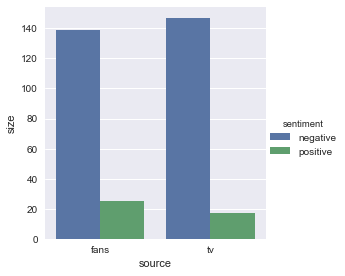

In [16]:
test_data = classify(train_data,test_data, LinearSVC())

#Plot the results using seaborn
agg=test_data.groupby(['sentiment','source']).size().reset_index()
agg.columns=['sentiment','source','size']
fig1 = sns.factorplot(x="source", y="size", hue="sentiment", data=agg, kind="bar")
sns.plt.show()

Before getting into the results, let me break down the graph a bit. On the y-axis we simply see the number of items that got sorted into each category. On the x-axis is the source material (so did these reddit comments come from fans or tv). 

Our model was pretty good at identifying items in the train set, but doesn't really seem to capture a difference here. I think it's worth it to also try a Multinomial Naive Bayes, which will assume independence of all the words being in a given comment.

In [17]:
print_model_acc(train_data, MultinomialNB())

0.82


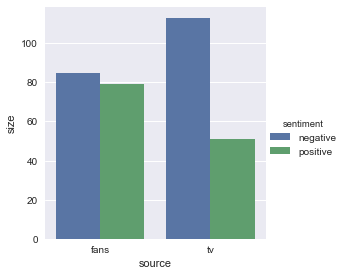

In [18]:
test_data = classify(train_data,test_data, MultinomialNB())

agg2=test_data.groupby(['sentiment','source']).size().reset_index()
agg2.columns=['sentiment','source','size']
fig1 = sns.factorplot(x="source", y="size", hue="sentiment", data=agg2, kind="bar")
sns.plt.show()

That captures way more nuance in the data than the LinearSVC and doesn't sacrifice any of the model's accuracy. This is probably because a Naive Bayes classifier has much more lax assumptions about the independence of the features of the model.

Just to be sure though let's look at a random comment for each sentiment.

In [23]:
pd.set_option('display.max_colwidth', -1)

print("Negative example:")
print(test_data.loc[test_data.sentiment=='negative','raw'].sample(1))
print()
print("Positive example:")
print(test_data.loc[test_data.sentiment=='positive','raw'].sample(1))
print("***************")

Negative example:
1    The dialogue and acting improves as it goes, but fuck it's slow. Every episode I've seen is at lest 15-20 minutes too long. 
Name: raw, dtype: object

Positive example:
276    Just finished watching the finale, really don't think it deserves the hate it's getting here. I thought it was pretty good; started off slow and not enough use of the Iron Fist, ended a bit weak but I thought the fight scenes were really cool and enjoyed the story (the bits with the Hand, anyway).
Name: raw, dtype: object
***************


Sorry for the profanity...but that's internet commenting for you.

Anyway, a decent classification difference! It's clear that the any one comment isn't going to be wholly positive or negative. These comments are clearly nuanced and the Multinomial Naive Bayes model seems to do an better job of catching general sentiment. 

<a id='section4'></a>
## Extracting and comparing topics

Ok, so now that we've looked at the sentiment, it's time to try to extract some topics. The overarching goal of this section is to see if different communities are talking about different things. To do that we are going to define two similar functions that vectorize the comments and fit them to an LDA model, which, given a number of proposed topics, will associates words with each topic in the model.

In [30]:
def source_topic_extraction(data, source, n_features, n_topics):
    #Vectorize comments
    vectorizer = CountVectorizer(min_df=5, max_features=n_features,stop_words='english')
    topic_vec = vectorizer.fit_transform(test_data[test_data.source == source].cleaned_comments)
    #Add and fit them to an LDA model
    lda_model = LatentDirichletAllocation(n_topics = n_topics, learning_method = 'online')
    lda_model.fit(topic_vec)
    feature_names = vectorizer.get_feature_names()
    return lda_model, feature_names

def sent_topic_extraction(data, sent, n_features, n_topics):
    #Nearly identical to the model above, but filters based on SENTIMENT instead of SOURCE
    vectorizer = CountVectorizer(min_df=5, max_features=n_features,stop_words='english')
    topic_vec = vectorizer.fit_transform(test_data[test_data.sentiment == sent].cleaned_comments)
    lda_model = LatentDirichletAllocation(n_topics = n_topics, learning_method = 'online')
    lda_model.fit(topic_vec)
    feature_names = vectorizer.get_feature_names()
    return lda_model, feature_names

#Given two topic models, prints top n words for each topic
def compare_topics(model1, feature_names1, model2, feature_names2, n_top_words):
    for topic_idx, topic in enumerate(model1.components_):
        print("Model 1 topic #%d:" % topic_idx)
        print(" ".join([feature_names1[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    for topic_idx, topic in enumerate(model2.components_):
        print("Model 2 topic #%d:" % topic_idx)
        print(" ".join([feature_names2[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))


Now let's build two models, one representing fans and the other representing tv.

In [48]:
fanmodel, fannames = source_topic_extraction(test_data, 'fans', 50, 2)
tvmodel, tvnames = source_topic_extraction(test_data, 'tv', 50, 2)
compare_topics(fanmodel, fannames, tvmodel, tvnames, 5)

Model 1 topic #0:
danny iron_fist fight series scene
Model 1 topic #1:
good far character enjoy watch

Model 2 topic #0:
watch bad good time review
Model 2 topic #1:
good daredevil fight luke_cage scene


The first model is that of the fans, and the second is that of the tv watchers.

I used relatively few topics because many of the comments are quite short, and too many comments with too many features would be kind of an overextension of our data. Given that, there are some obvious differences in topics. Topics from fans discuss the characters and the fighting, while TV posters compare Iron Fist to Daredevil and Luke Cage.

I think, to some degree, this supports the idea that these two communities are focusing on different things, with the most obvious difference being that the tv posters immediately compare Iron Fist to the other Netflix shows.

To take it one step further, I'll do two topic analyses, separated by sentiment rather than community.

In [49]:
posmodel, posnames = sent_topic_extraction(test_data, 'positive', 50, 2)
negmodel, negnames = sent_topic_extraction(test_data, 'negative', 50, 2)
compare_topics(posmodel, posnames, negmodel, negnames, 5)

Model 1 topic #0:
great danny good iron_fist enjoy
Model 1 topic #1:
fight marvel come choreography good

Model 2 topic #0:
bad daredevil enjoy netflix far
Model 2 topic #1:
good danny fight character scene


Definitely take these results with a grain of salt. Almost all of the positive comments come from the fans community, so it isn't as nice a split as the last analysis.

That said, there are a few trends that differ. The positive comments seem to mention the fight choreography, while the negative comments talk about the characters.

<a id='conc'></a>
## Conclusion

What have we learned? 

1. Fans clearly have more mixed opinions than the more general tv audience. 
2. The topics these fans care about vary, if only somewhat.


I was altogether pretty happy with this code. Using SpaCy instead of nltk was a bit new, but was pretty simple, and will likely do a good job of scaling up if I get more comments. 


Some drawbacks/limitations:
1. Reddit comments aren't typically very long...longer reviews from another site would probably contribute better to the models, though there are likely to be fewer reviews.
2. This code doesn't capture reddit's upvote/downvote system. In an ideal world, I'd like to be able to weigh some comments as more influential, based on their score, to reflect that many people who come to the comment section simply agree and move on. 
3. The code needs manual bigrams for names, which is somewhat limiting to its generalizability. In the next iteration I want to add code that finds common bigrams and combines them.


This code is otherwise pretty flexible and should be usable to compare the sentiment and topics of any two reddit threads given two links (and some edited stopwords). Iron Fist was a nice innocent example because there was a strong precedent for differing opinions between communities, but I think this would work just as well for posts from different political communities, religious communities etc.